# 3.4 내 여자친구 최애 쿠션 찾아 주기

In [9]:
import re # 정규 표현식

import pandas as pd 
import numpy as np
import os
from kiwipiepy import Kiwi # 형태소 분석
from collections import Counter # 다빈도 단어 분석
import warnings
warnings.filterwarnings("ignore")
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic')
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

import seaborn as sns

import calendar

from dateutil.parser import parse

from collections import Counter
from konlpy.tag import Komoran, Okt, Twitter
from pprint import pprint

basic_info_path = './data/makeup_basic_info/'

basic_info_files = os.listdir(basic_info_path)
print("제품 기본 정보 데이터 수:", len(basic_info_files))

제품 기본 정보 데이터 수: 975


In [2]:
pattern = re.compile(r'^\d+_info\.xlsx$')
basic_info_files = [file for file in os.listdir(basic_info_path) if pattern.match(file)]
df_bsc_inf_tmp = [pd.read_excel(basic_info_path+file) for file in basic_info_files]
df_bsc = pd.concat(df_bsc_inf_tmp)
df_bsc.reset_index(drop=True, inplace=True)
df_bsc.head(2)

,name,tag,likes,num_review,num_photo,url,sale_day
0,0번_제품,"['#촉촉한수분감', '#촉촉한사용감', '#윤기커버', '#부드러운사용감', '#...","찜4,203",50,(20건),https://cr.shopping.naver.com/adcr.nhn?x=hgdmo...,등록일 2022.01.
1,100번_제품,"['#보송보송한메이크업', '#부드러운피부', '#인생템', '#헤라블랙쿠션', '...",찜62,1,(1건),https://cr.shopping.naver.com/adcr.nhn?x=DToeQ...,등록일 2022.05.


## 3.4.2 제품 기본 정보 데이터 전처리

In [3]:
#df_bsc.to_excel(basic_info_path+'basic_info.xlsx', index=False)
df_bsc = pd.read_excel(basic_info_path+'basic_info.xlsx')

In [4]:
df_bsc.rename(columns={"name":"제품기호", "sale_day":"dates", "tag":"HashTag"}, inplace=True)

def get_digit_only(text):
    """숫자만 추출한다."""
    if text != '없음':
        tmp = re.compile('[0-9]+').findall(str(text))

        result = ''.join(tmp)

        return int(result)
    else:
        return 0
    
print("찜한 수 전처리 결과 예시:", get_digit_only(text='찜4,203'))
print("리뷰 수 전처리 결과 예시:", get_digit_only(text='1,221'))
print("포토 리뷰 수 전처리 결과 예시:", get_digit_only(text='(173건)')) 

찜한 수 전처리 결과 예시: 4203
리뷰 수 전처리 결과 예시: 1221
포토 리뷰 수 전처리 결과 예시: 173


In [5]:
df_bsc['likes'] = df_bsc['likes'].astype('str')
df_bsc['num_review'] = df_bsc['num_review'].astype('str')
df_bsc['num_photo'] = df_bsc['num_photo'].astype('str')

df_bsc['likes'] = df_bsc['likes'].apply(lambda x:get_digit_only(x))
df_bsc['num_review'] = df_bsc['num_review'].apply(lambda x:get_digit_only(x))
df_bsc['num_photo'] = df_bsc['num_photo'].apply(lambda x: get_digit_only(x))


In [6]:
df_bsc['dates'] = df_bsc['dates'].apply(lambda x:x.replace('등록일', ''))
df_bsc['year'] = df_bsc['dates'].apply(lambda x:x[:5])
df_bsc['month'] = df_bsc['dates'].apply(lambda x: x[-4:-1].replace('.',''))
df_bsc.head(2)

,제품기호,HashTag,likes,num_review,num_photo,url,dates,year,month
0,0번_제품,"['#촉촉한수분감', '#촉촉한사용감', '#윤기커버', '#부드러운사용감', '#...",4203,50,20,https://cr.shopping.naver.com/adcr.nhn?x=hgdmo...,2022.01.,2022,01
1,100번_제품,"['#보송보송한메이크업', '#부드러운피부', '#인생템', '#헤라블랙쿠션', '...",62,1,1,https://cr.shopping.naver.com/adcr.nhn?x=DToeQ...,2022.05.,2022,05


Text(0, 0.5, '등록수')

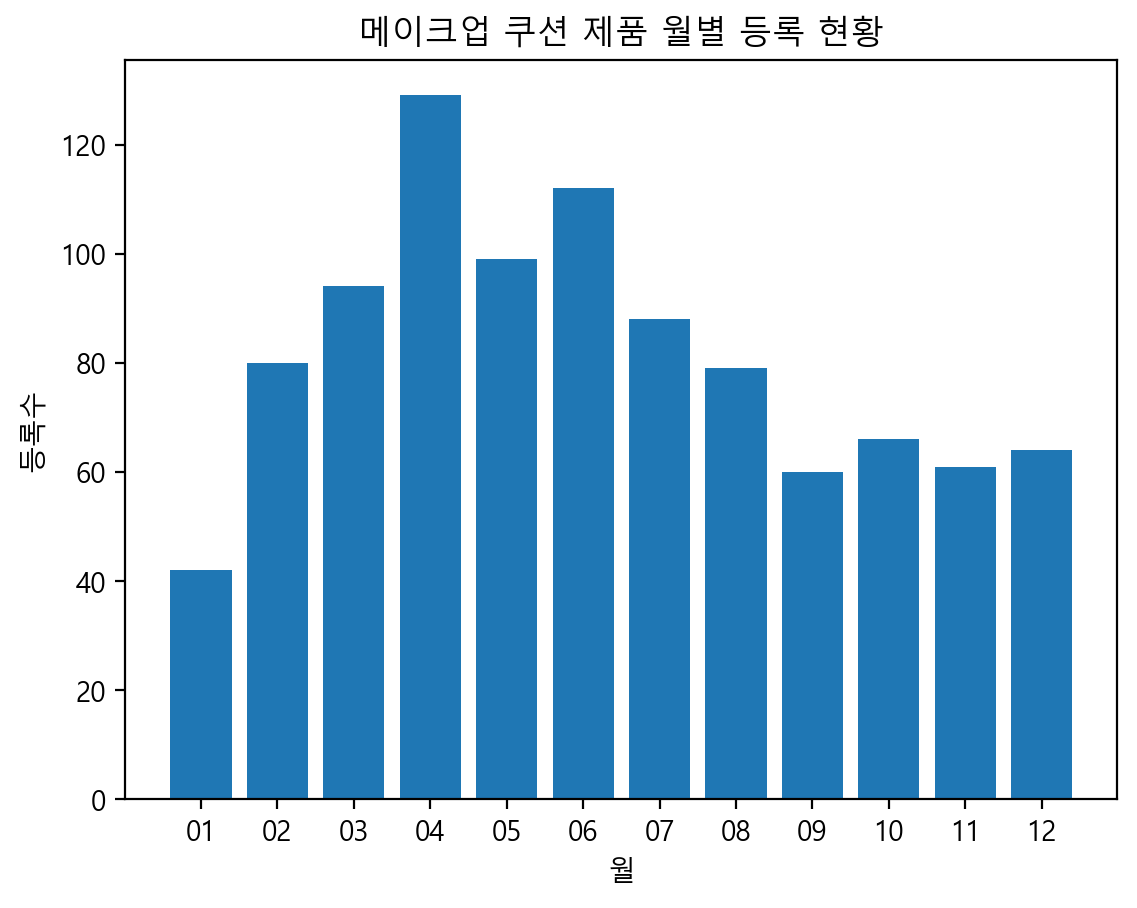

In [7]:
x = df_bsc['month'].value_counts().sort_index().index
y = df_bsc['month'].value_counts().sort_index().values

plt.title('메이크업 쿠션 제품 월별 등록 현황')
plt.bar(x, y)
plt.xlabel('월')
plt.ylabel('등록수')

### 해시태크 전처리

In [8]:
df_bsc['HashTag'][0]

"['#촉촉한수분감', '#촉촉한사용감', '#윤기커버', '#부드러운사용감', '#생기있는', '#윤기나는얼굴', '#지속력좋은파운데이션', '#30대여성', '#20대여성']"

In [12]:
tags = literal_eval(df_bsc['HashTag'][0])
tags

['#촉촉한수분감',
 '#촉촉한사용감',
 '#윤기커버',
 '#부드러운사용감',
 '#생기있는',
 '#윤기나는얼굴',
 '#지속력좋은파운데이션',
 '#30대여성',
 '#20대여성']

In [13]:
df_bsc_tmp = []
for i in range(df_bsc.shape[0]):
    tags = literal_eval(df_bsc['HashTag'][i])
    df_tmp = pd.DataFrame({
        "제품기호":df_bsc['제품기호'][i],
        "dates":df_bsc['dates'][i],
        "HashTag":tags,
        "likes":df_bsc['num_review'][i],
        'num_photo':df_bsc['num_photo'][i],
        'year':df_bsc['year'][i],
        'month':df_bsc['month'][i]
                           })
    df_bsc_tmp.append(df_tmp)
df_bsc_rslt = pd.concat(df_bsc_tmp)

df_bsc_rslt.head(3)

,제품기호,dates,HashTag,likes,num_photo,year,month
0,0번_제품,2022.01.,#촉촉한수분감,50,20,2022,01
1,0번_제품,2022.01.,#촉촉한사용감,50,20,2022,01
2,0번_제품,2022.01.,#윤기커버,50,20,2022,01


In [14]:
df_bsc_rslt.to_excel(basic_info_path+'basic_info_result.xlsx')

### 3.4.4 해시태그 분석으로 제품 트렌드 변화 관찰